In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL as pil
import os

**HPARAMS**

In [2]:
BATCH_SIZE = 1024

In [3]:
IMG_SIZE = (64, 64)

**Load Data**

In [4]:
DATA_DIR = "dataset"

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 24357 files belonging to 4 classes.
Using 19486 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 24357 files belonging to 4 classes.
Using 4871 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['black', 'blue', 'green', 'yellow']


**Visualize Data**

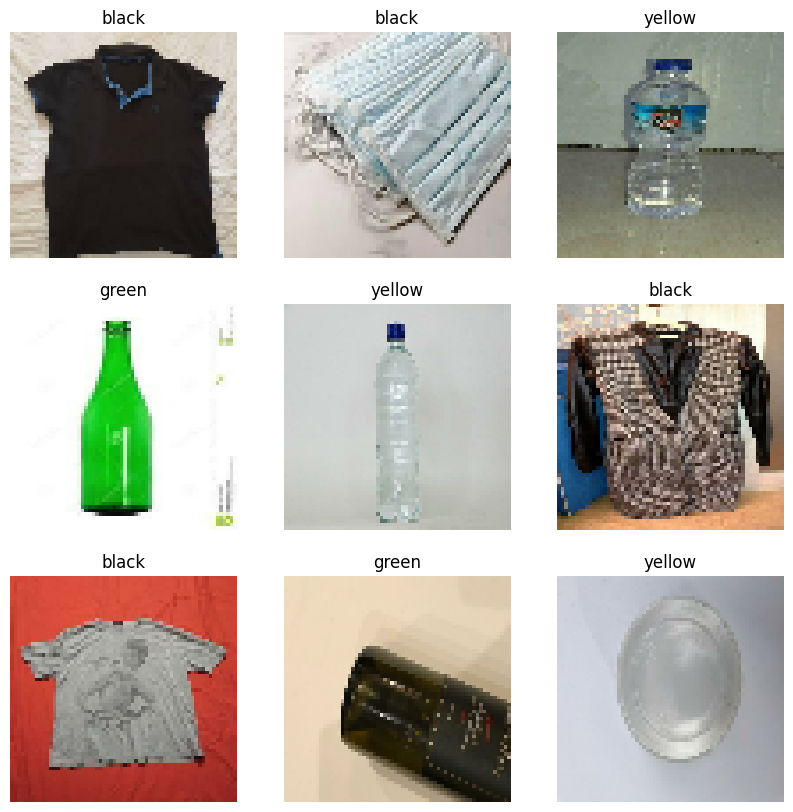

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(1024, 64, 64, 3)
(1024,)


**Preprocess Data**

In [10]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Utilitary**

In [13]:
def path_exists(path: str) -> str:
    if os.path.exists(path):
        i = 0
        while True:
            new_path = f"{path}_{i}"
            if not os.path.exists(new_path):
                return new_path
            i += 1
    return path

**Model**

In [14]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=(64, 64, 3)))

# Conv & pooling tf.keras.layers
model.add(tf.keras.layers.Conv2D(4, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.Conv2D(4, (3, 3), activation='tanh', padding='same'))
model.add(tf.keras.layers.MaxPool2D())

# Fully connected tf.keras.layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 4)         112       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 4)         148       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 4)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 8)                 32776     
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                        

In [17]:
model.fit(train_ds,
          validation_data=val_ds,
          epochs=10,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
                     tf.keras.callbacks.TensorBoard(log_dir=f"{path_exists('tensorlogs/logs')}")])
loss, accuracy = model.evaluate(val_ds)
model.save(f"models/model_loss_{loss}_acc_{accuracy}.h5")

Epoch 1/10
20/20 [==============================] - 90s 4s/step - loss: 2.3593 - accuracy: 0.3273 - val_loss: 1.3623 - val_accuracy: 0.4048
Epoch 2/10
20/20 [==============================] - 26s 1s/step - loss: 1.3493 - accuracy: 0.4141 - val_loss: 1.3400 - val_accuracy: 0.4048
Epoch 3/10
20/20 [==============================] - 27s 1s/step - loss: 1.3305 - accuracy: 0.4141 - val_loss: 1.3303 - val_accuracy: 0.4048
Epoch 4/10
20/20 [==============================] - 26s 1s/step - loss: 1.3230 - accuracy: 0.4141 - val_loss: 1.3276 - val_accuracy: 0.4048
Epoch 5/10
20/20 [==============================] - 27s 1s/step - loss: 1.3207 - accuracy: 0.4141 - val_loss: 1.3271 - val_accuracy: 0.4048
Epoch 6/10
20/20 [==============================] - 25s 1s/step - loss: 1.3201 - accuracy: 0.4141 - val_loss: 1.3271 - val_accuracy: 0.4048
Epoch 7/10
20/20 [==============================] - 26s 1s/step - loss: 1.3199 - accuracy: 0.4141 - val_loss: 1.3271 - val_accuracy: 0.4048
Epoch 8/10
20/20 [==

**Testing Model**

In [ ]:
model = tf.keras.models.load_model("models/model_loss_0.41599953174591064_acc_0.8107670545578003.h5")

In [ ]:
img = pil.Image.open("testing/briatte.png").resize(IMG_SIZE)
img = np.array(img)

In [ ]:
predictions = model.predict(img[None, :, :]).argmax(axis=1)

In [ ]:
predictions